In [1]:
import sys
import os

package_path: str = '../..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from src.analyzer.converter import load_npz
from src.filesystem import get_run_scan_directory
from src.config.config import load_config, ExpConfig


config: ExpConfig = load_config()
config.path

ExpPaths(log_dir='./logs', load_dir='Z:\\230518_FXS\\raw_data\\h5\\type=raw', analysis_dir='Z:\\230518_FXS\\analysis_data', mat_dir='Z:\\230518_FXS\\analysis_data\\mat_files', processed_dir='Z:\\230518_FXS\\analysis_data\\processed_data', output_dir='Z:\\230518_FXS\\analysis_data\\output_data')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from roi_rectangle import RoiRectangle

In [9]:
processed_dir: str = config.path.processed_dir
run_n: int = 145
npz_file: str = os.path.join(processed_dir, f"run={run_n:0>4}_scan=0001.npz")

_data: dict[str: npt.NDArray] = load_npz(npz_file)
delays: npt.NDArray = _data["delay"]
pons: npt.NDArray = _data["pon"]
poffs: npt.NDArray = _data["poff"]

print(f"{delays.shape = }")
print(f"{pons.shape = }")
print(f"{poffs.shape = }")

delays.shape = (120,)
pons.shape = (120, 514, 1030)
poffs.shape = (120, 514, 1030)


In [11]:
poffs = np.maximum(0, poffs)

Text(0.5, 1.0, 'Pump Off Images Sum')

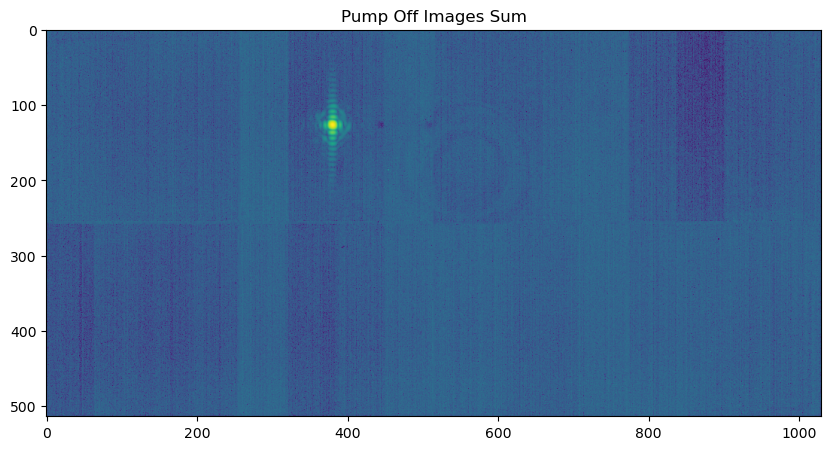

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(poffs.sum(0)))
ax.set_title("Pump Off Images Sum")

RoiRectangle(x1=352, y1=98, x2=411, y2=159)

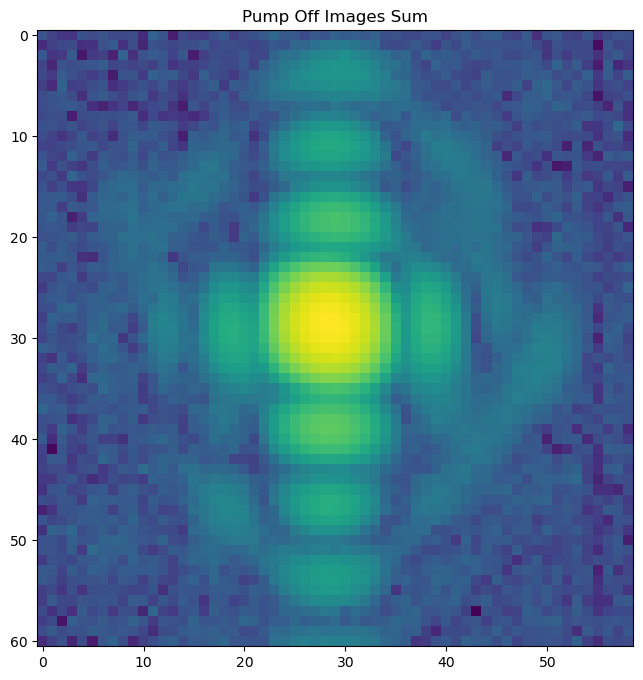

In [13]:
roi_rect: RoiRectangle = RoiRectangle(x1=352, y1=98, x2=411, y2=159)
roi_poffs: npt.NDArray = roi_rect.slice(poffs)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(roi_poffs.sum(0)))
ax.set_title("Pump Off Images Sum")

roi_rect

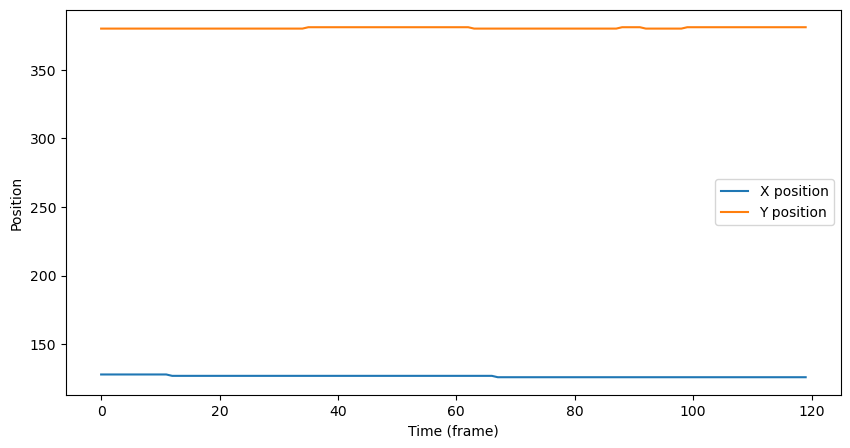

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter


# 가우시안 커널 생성
kernel_size = 11
sigma = 2
kernel = np.outer(np.hanning(kernel_size), np.hanning(kernel_size))
kernel /= kernel.sum()

# 각 프레임에서 픽의 위치를 찾기 위한 함수
def find_peak_position(frame, kernel):
    # 컨볼루션 수행
    conv = convolve2d(frame, kernel, mode='same')
    # 최대값 위치 찾기
    peak_position = np.unravel_index(np.argmax(conv), conv.shape)
    return peak_position

# 시간에 따른 픽의 위치 추적
peak_positions = []
for frame in poffs:
    peak_position = find_peak_position(frame, kernel)
    peak_positions.append(peak_position)

peak_positions = np.array(peak_positions)

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(peak_positions[:, 0], label='X position')
plt.plot(peak_positions[:, 1], label='Y position')
plt.xlabel('Time (frame)')
plt.ylabel('Position')
plt.legend()
plt.show()